In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

In [3]:
def read_fidelities(file):
    fidelities = []

    for γ_i in γ_list:

        with h5py.File(file, 'r') as f:
                
            fidelity_list = [f[γ_i][f"D{i}"]["Fidelity"][...] for i in range(1, 11)  if f[γ_i][f"D{i}"]["Fidelity"].size > 0]
            concatenated_list = [item for lst in fidelity_list for item in lst] 
            fidelities.append(concatenated_list) 
    
    return(fidelities)

def read_rank5_fidelities(file):
    fidelities_dmd = []
    fidelities_era = []

    for γ_i in γ_list:

        with h5py.File(file, 'r') as f:
                
            fidelity_dmd_list = [f[γ_i][f"D{i}"]["F_dmd_sb"][...] for i in range(1, 11)  if f[γ_i][f"D{i}"]["F_dmd_sb"].size > 0]
            concatenated_dmd_list = [item for lst in fidelity_dmd_list for item in lst] 
            fidelities_dmd.append(concatenated_dmd_list) 

            fidelity_era_list = [f[γ_i][f"D{i}"]["F_era_sb"][...] for i in range(1, 11)  if f[γ_i][f"D{i}"]["F_era_sb"].size > 0]
            concatenated_era_list = [item for lst in fidelity_era_list for item in lst] 
            fidelities_era.append(concatenated_era_list) 
    
    return(fidelities_dmd, fidelities_era)


In [4]:
import pickle

def read_fidelities_from_pickled_df(file_name):

    # Open the pickle file in read mode ('rb' stands for 'read binary')
    with open(file_name, 'rb') as file:
        combined_df = pickle.load(file)
    
    grouped = combined_df.groupby(['Gamma'])['Fidelity'].apply(list).reset_index()

    fidelities = grouped['Fidelity'].tolist()

    return(fidelities)

In [5]:
with open("../NonMark.pkl", 'rb') as file:
        NonMark = pickle.load(file)

NonMark

array([1.54209546e-04, 1.29291467e-02, 5.91358315e-05, 7.10188411e-04,
       3.46324351e-02, 4.18774649e-02, 3.01774778e-03, 6.39944833e-04])

In [6]:
with open("PositiveEigenVals.pkl", 'rb') as file:
        PosEvals = pickle.load(file)
PosEvals

[4.4408920985004545e-14,
 6.661338148421409e-13,
 0,
 5.329070518199586e-13,
 3.1086244689505304e-12,
 2.2204460492503237e-11,
 0,
 4.440892098502705e-12]

In [7]:
kossak_tssos_fids = read_fidelities("../KOSSAK_CONSTR_TSSOS_treshold_1e-15_FROB_QO_2024-Sep-06_at_11-57.h5")

lindblad_tssos_fids = read_fidelities("../LINDBLAD4_CONSTR_TSSOS_treshold_1e-9_FROB_QO_2024-Sep-06_at_16-19.h5")

benchmark_slsqp_fids = read_fidelities("../BENCHMARK_TEST_BENCHMARK_KossakConstrFrob_Jump_NLOPT_LD_SLSQP2024-Sep-15_at_10-53.h5")

zhang_sarovar_fids = read_fidelities("ZHANG_SAROVAR_DMD_B4_KOSSAK_CONSTR_TSSOS_treshold_1e-15_FROB_QO_2024-Sep-16_at_14-34.h5")

dmd4_fids = read_fidelities("DMD-Bloch4D_SB_trn4_tst20_2024-Sep-16_at_13-37.h5")

fidelities_dmd5, fidelities_era5 = read_rank5_fidelities("DMDvsERA_rank5_SB_trn4_tst10_2024-Sep-16_at_16-27.h5")

In [8]:
min(dmd4_fids[7])

0.7243544467052858

In [9]:
import matplotlib.patches as mpatches

labels = []

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

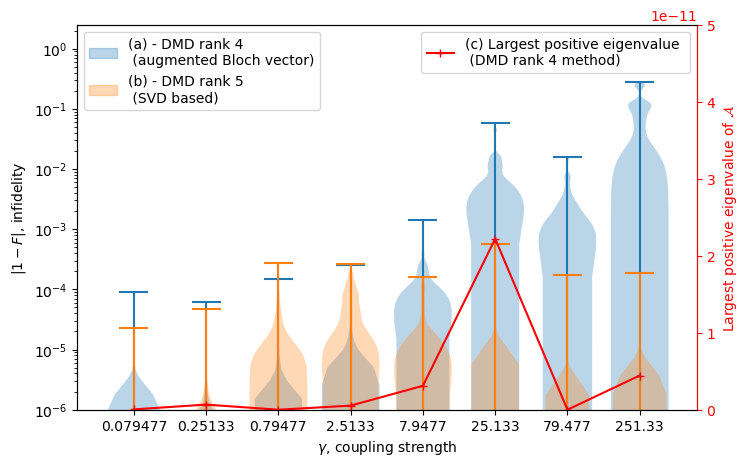

In [10]:
labels = []

# Create the first plot
fig, ax1 = plt.subplots(figsize=(8, 5))

#add_label(ax1.violinplot([1-np.abs(_)  for _ in benchmark_slsqp_fids], showextrema=True, widths=0.6), "(c) - Infidelity of Benchmark method") 

#add_label(ax1.violinplot([1-np.min(_)  for _ in kossak_tssos_fids[:4]] + [1-np.abs(_)  for _ in kossak_tssos_fids[4:]], showextrema=True, widths=0.8),"(a) - Infidelity of Kossakowski model")

#add_label(ax1.violinplot([1-np.abs(_)  for _ in lindblad_tssos_fids[:4]], showextrema=True, widths=0.8), "(b) - Infidelity of Lindblad ansatz")

add_label(ax1.violinplot([1-np.abs(_)  for _ in dmd4_fids], showextrema=True, widths=0.8), "(a) - DMD rank 4 \n (augmented Bloch vector)")

add_label(ax1.violinplot([1-np.abs(_)  for _ in fidelities_dmd5], showextrema=True, widths=0.8), "(b) - DMD rank 5 \n (SVD based)")

#showmedians=True, 


ax2 = ax1.twinx()
ax2.plot(np.arange(1,9), PosEvals, marker="+", color="red", label = "(c) Largest positive eigenvalue \n (DMD rank 4 method)")
#ax2.set_yscale('log')
ax2.set_ylim(0, 1e-10/2)
ax2.set_ylabel(r'Largest positive eigenvalue of $\mathcal{A}$ ', color='red')

ax1.set_yscale('log')
ax1.set_ylim(1e-6, 2.5)

#ax1.tight_layout()

ax1.set_xticks(range(1, len(γ_list) + 1), γ_list )
ax1.set_xlabel("$\gamma$, coupling strength")

ax1.set_ylabel("$|1 - F|$, infidelity")

ax1.legend(*zip(*labels), loc=2)

# Changing the color of the second y-axis
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(loc=1)

#ax1.set_title("Performance of Markovian models for spin boson system")

fig.savefig("DMD_Bloch4-5.pdf")

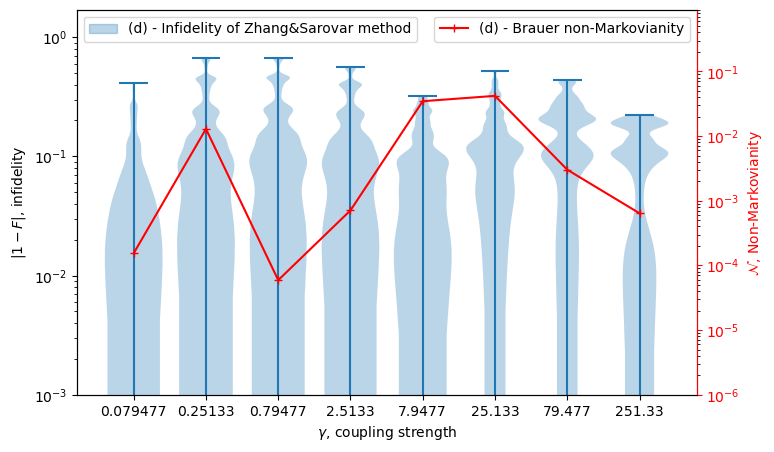

In [24]:
labels = []

# Create the first plot
fig, ax1 = plt.subplots(figsize=(8, 5))

#add_label(ax1.violinplot([1-np.abs(_)  for _ in benchmark_slsqp_fids], showextrema=True, widths=0.6), "(c) - Infidelity of Benchmark method") 

#add_label(ax1.violinplot([1-np.min(_)  for _ in kossak_tssos_fids[:4]] + [1-np.abs(_)  for _ in kossak_tssos_fids[4:]], showextrema=True, widths=0.8),"(a) - Infidelity of Kossakowski model")

#add_label(ax1.violinplot([1-np.abs(_)  for _ in lindblad_tssos_fids[:4]], showextrema=True, widths=0.8), "(b) - Infidelity of Lindblad ansatz")

add_label(ax1.violinplot([1-np.abs(_)  for _ in zhang_sarovar_fids], showextrema=True, widths=0.8), "(d) - Infidelity of Zhang&Sarovar method")

#showmedians=True, 


ax2 = ax1.twinx()
ax2.plot(np.arange(1,9), NonMark, marker="+", color="red", label = "(d) - Brauer non-Markovianity")
ax2.set_yscale('log')
ax2.set_ylim(1e-6, .9)
ax2.set_ylabel('$\mathcal{N}$, Non-Markovianity', color='red')

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1.7)

#ax1.tight_layout()

ax1.set_xticks(range(1, len(γ_list) + 1), γ_list )
ax1.set_xlabel("$\gamma$, coupling strength")

ax1.set_ylabel("$|1 - F|$, infidelity")

ax1.legend(*zip(*labels), loc=2)

# Changing the color of the second y-axis
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(loc=1)

#ax1.set_title("Performance of Markovian models for spin boson system")

#fig.savefig("ZHANG&SAROVAR_KOSSAK_CONSTR_TSSOS.pdf")

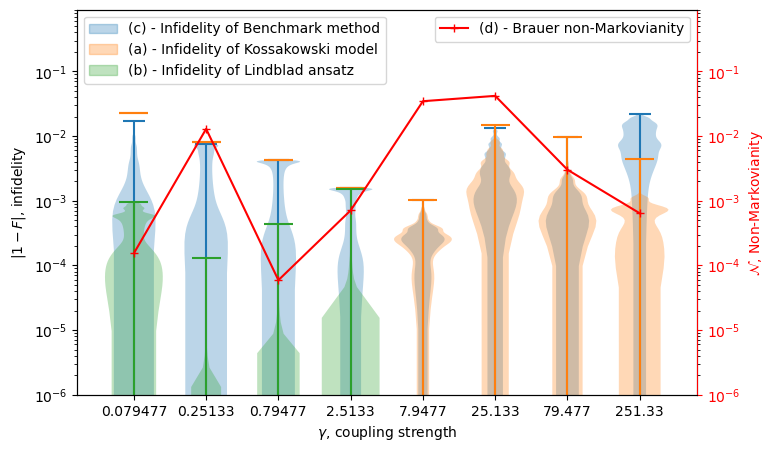

In [15]:
labels = []

# Create the first plot
fig, ax1 = plt.subplots(figsize=(8, 5))

add_label(ax1.violinplot([1-np.abs(_)  for _ in benchmark_slsqp_fids], showextrema=True, widths=0.6), "(c) - Infidelity of Benchmark method") 

add_label(ax1.violinplot([1-np.min(_)  for _ in kossak_tssos_fids[:4]] + [1-np.abs(_)  for _ in kossak_tssos_fids[4:]], showextrema=True, widths=0.8),"(a) - Infidelity of Kossakowski model")

add_label(ax1.violinplot([1-np.abs(_)  for _ in lindblad_tssos_fids[:4]], showextrema=True, widths=0.8), "(b) - Infidelity of Lindblad ansatz")

#add_label(ax1.violinplot([1-np.abs(_)  for _ in zhang_sarovar_fids], showextrema=True, widths=0.8), "(d) - Infidelity of Zhang&Sarovar method")

#showmedians=True, 


ax2 = ax1.twinx()
ax2.plot(np.arange(1,9), NonMark, marker="+", color="red", label = "(d) - Brauer non-Markovianity")
ax2.set_yscale('log')
ax2.set_ylim(1e-6, .9)
ax2.set_ylabel('$\mathcal{N}$, Non-Markovianity', color='red')

ax1.set_yscale('log')
ax1.set_ylim(1e-6, .9)

#ax1.tight_layout()

ax1.set_xticks(range(1, len(γ_list) + 1), γ_list )
ax1.set_xlabel("$\gamma$, coupling strength")

ax1.set_ylabel("$|1 - F|$, infidelity")

ax1.legend(*zip(*labels), loc=2)

# Changing the color of the second y-axis
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(loc=1)

#ax1.set_title("Performance of Markovian models for spin boson system")

#fig.savefig("SB_SID_LINDBLAD&KOSSAK_CONSTR_TSSOS.pdf")

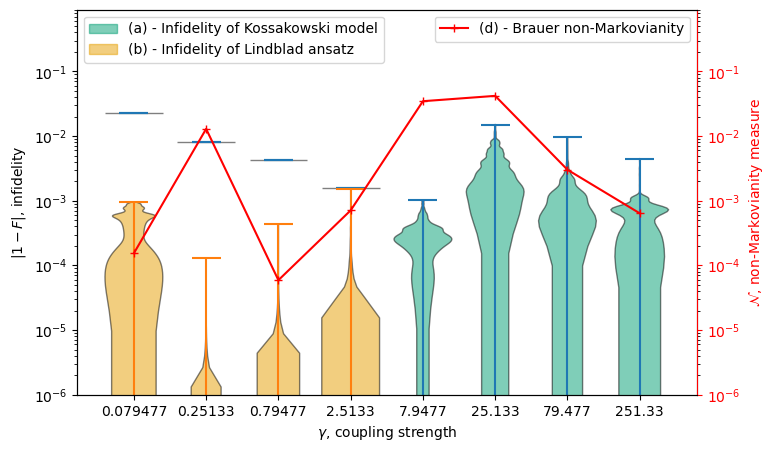

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define a color-blind-friendly palette (Okabe-Ito)
#color_blind_palette = ['#E69F00', '#56B4E9', '#009E73']  # Three distinct colors
#color_blind_palette = ['#E69F00', '#F0E442', '#D55E00']  # Orange, Yellow, Red
color_blind_palette = ['#009E73', '#E69F00', '#CC79A7']  # Green, Orange, Purple

# Function to set the colors and transparency of the violin plot bodies
def set_violin_colors(violin, color, alpha=0.5):
    for body in violin['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(alpha)

labels = []

# Create the first plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Create the first violin plot and set its color (first color in the palette)
violin1 = plt.violinplot([1-np.min(_) for _ in kossak_tssos_fids[:4]] + [1-np.abs(_) for _ in kossak_tssos_fids[4:]], showextrema=True, widths=0.8)
set_violin_colors(violin1, color_blind_palette[0], alpha=0.5)
add_label(violin1, "(a) - Infidelity of Kossakowski model")

# Create the second violin plot and set its color (second color in the palette)
violin2 = ax1.violinplot([1-np.abs(_) for _ in lindblad_tssos_fids[:4]], showextrema=True, widths=0.8)
set_violin_colors(violin2, color_blind_palette[1], alpha=0.5)
add_label(violin2, "(b) - Infidelity of Lindblad ansatz")

# Create the third violin plot and set its color (third color in the palette)
#violin3 = ax1.violinplot([1-np.abs(_) for _ in jump_fids], showextrema=True, widths=0.6)
#set_violin_colors(violin3, color_blind_palette[2], alpha=0.5)
#add_label(violin3, "(c) - Infidelity of Benchmark method")

# Adding a second y-axis and plotting data
ax2 = ax1.twinx()
ax2.plot(np.arange(1, 9), NonMark, marker="+", color="red", label="(d) - Brauer non-Markovianity")
ax2.set_yscale('log')
ax2.set_ylim(1e-6, .9)
ax2.set_ylabel('$\mathcal{N}$, non-Markovianity measure', color='red')

# Customizing the primary y-axis
ax1.set_yscale('log')
ax1.set_ylim(1e-6, .9)
ax1.set_xticks(range(1, len(γ_list) + 1), γ_list)
ax1.set_xlabel("$\gamma$, coupling strength")
ax1.set_ylabel("$|1 - F|$, infidelity")

# Adding legends
ax1.legend(*zip(*labels), loc=2)

# Customizing the secondary y-axis
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(loc=1)

# Display the plot
plt.show()

#fig.savefig("SB_SID_LINDBLAD&KOSSAK_CONSTR_TSSOS_color-blind.pdf")